In [ ]:
#default_exp audio.core
#default_cls_lvl 3

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.notebook.showdoc import show_doc
import torchaudio
import torchaudio.transforms as torchaud_tfm

from IPython.display import display, Audio
from dataclasses import dataclass, asdict
from torchaudio.transforms import Spectrogram, AmplitudeToDB, MFCC, MelScale

In [ ]:
torchaudio.__version__

'0.3.0+faed00e'

In [ ]:
TensorBase??

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Create __all__ for audio</div>

In [ ]:
#export
_all_ = ['AudioGetter', 'get_audio_files', 'AudioItem', 'OpenAudio', 'AudioSpectrogram', 'AudioToSpec',
        'SpectrogramConfig', 'AudioConfig', 'audio_extensions']

## Basic types

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
#export
audio_extensions = tuple(str.lower(k) for k, v in mimetypes.types_map.items() if v.startswith('audio/'))

In [ ]:
#export
def get_audio_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
#export
def AudioGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): 
        return get_audio_files(o/suf, recurse, folders)
    return _inner

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Get data_url stuff working</div>

In [ ]:
# data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
# data_folder = download_url(data_url, get_path(data_url))

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')

In [ ]:
p.ls()

(#3844) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
audio_get_func = AudioGetter("", recurse=True, folders=None)

In [ ]:
audio_get_func

<function __main__.AudioGetter.<locals>._inner(o, recurse=True, folders=None)>

In [ ]:
files = audio_get_func(p)

In [ ]:
files[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br> 
    1. Return to lazy loading. <br>
    2. Refactor out @property pattern using the fastai v2 way <br>
    3. Get rid of path as part of the tuple? <br>
</div>

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Factor</div

In [ ]:
#export
class AudioItem(tuple):
    def show(self, ctx=None, **kwargs): 
        print(f"File: {self.path}")
        display(Audio(self.sig, rate=self.sr))
    
    @classmethod
    def create(cls, fn, **kwargs):
        sig, sr = torchaudio.load(fn)
        return cls((sig, sr, fn), **kwargs)
    
    @property
    def sig(self) : return self[0]
    @property
    def sr(self)  : return self[1]
    @property
    def path(self): return self[2]
    @property
    def duration(self): return self.nsamples/float(self.sr)
    @property
    def nsamples(self): return self.sig.shape[-1]
    @property
    def nchannels(self): return self.sig.shape[0]

In [ ]:
type(AudioItem((None, None, files[0])))

__main__.AudioItem

In [ ]:
test_item = AudioItem.create(files[0]); test_item

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
          -6.1035e-05, -1.8311e-04]]),
 16000,
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav'))

In [ ]:
test_item[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
         -6.1035e-05, -1.8311e-04]])

In [ ]:
test_item.sr, test_item.duration, test_item.nchannels, test_item.nsamples

(16000, 3.28, 1, 52480)

In [ ]:
test_item.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


In [ ]:
#export
class OpenAudio(Transform):
    def __init__(self, items):
        self.items = items

    def encodes(self, i):
        o = self.items[i]
        return AudioItem.create(o)
    
    def decodes(self, i)->Path: 
        return self.items[i]

repr of Transform is:  
classname: self.use_as_item {self.encodes} {self.decodes}  
encodes and decodes are TypeDispatches whose reprs are str of dict where k/v pair is typename and function that handles that type

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: True {'object': 'encodes'} {'object': 'decodes'}

In [ ]:
type(oa)

__main__.OpenAudio

In [ ]:
#??Transform
#??TypeDispatch

In [ ]:
oa.encodes(1)

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.0518e-05,
          -1.2207e-04,  1.8311e-04]]),
 16000,
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav'))

In [ ]:
oa.decodes(1)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav')

In [ ]:
oa.items[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')

## Audio Spectrogram

In [ ]:
# TensorImageBase??
# TensorImage??
# TensorBase??
# Tensor??
# BypassNewMeta??

<div class='alert alert-block alert-warning'><strong>CAUTION:</strong> Extending TensorImageBase may not be 
    what we want to do as it's show method appears to be displaying a compressed x-axis to make the images fit in the case
    that they are wider than 200px </div>

In [ ]:
#export
class SpectralBase(TensorImageBase):
    @property
    def nchannels(self): return self.shape[0]
    @property
    def height(self): return self.shape[1]
    @property
    def width(self): return self.shape[2]

In [ ]:
#export
class AudioSpectrogram(SpectralBase):
    @classmethod
    def create(cls, sg, settings=None, path=None, start=None, end=None):
        x = cls(sg)
        store_attr(x, 'settings,path,start,end')
        return x

In [ ]:
#export
class MelSpectrogram(AudioSpectrogram):
    @classmethod
    def create(cls, sg, settings=None, path=None, start=None, end=None):
        x = cls(sg)
        store_attr(x, 'settings,path,start,end')
        return x

In [ ]:
#export
class AudioMFCC(SpectralBase):
    @classmethod
    def create(cls, sg, settings=None, path=None, start=None, end=None):
        x = cls(sg)
        store_attr(x, 'settings,path,start,end')
        return x

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br>
    1. Remove SpectrogramConfig/settings and just dump all settings in the function?</div><br>

In [ ]:
#export
@delegates(torchaud_tfm.Spectrogram.__init__)
def AudioToSpec(cfg, **kwargs):
    def _inner(ai:AudioItem)->AudioSpectrogram:
        sg = Spectrogram(**cfg)(ai.sig)
        return AudioSpectrogram.create(sg)
    return _inner
cfg = {'n_fft':2560,'hop_length':256}

In [ ]:
#export
@delegates(torchaud_tfm.MelSpectrogram.__init__)
def AudioToMelSpec(cfg, **kwargs):
    def _inner(ai:AudioItem)->MelSpectrogram:
        sg = torchaud_tfm.MelSpectrogram(ai.sr, **cfg)(ai.sig)
        return MelSpectrogram.create(sg.detach())        
    return _inner

In [ ]:
#export
@delegates(torchaud_tfm.MFCC.__init__)
def AudioToMFCC(cfg, **kwargs):
    def _inner(ai:AudioItem)->AudioSpectrogram:
        mfcc = MFCC(sample_rate=ai.sr, **cfg)(ai.sig)
        return AudioSpectrogram.create(mfcc.detach())        
    return _inner

In [ ]:
#export
@delegates(torchaud_tfm.AmplitudeToDB.__init__)
def AmplitudeToDB(power=2, top_db=80, **kwargs):
    def _inner(sg:AudioSpectrogram)->AudioSpectrogram:
        db_scale = torchaud_tfm.AmplitudeToDB(power, top_db)(sg)
        return AudioSpectrogram.create(db_scale.detach())        
    return _inner

### MelSpecPipe

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00340.wav


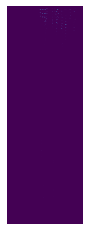

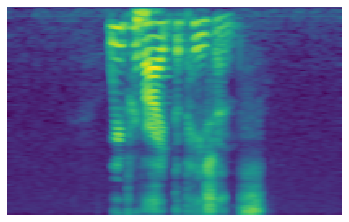

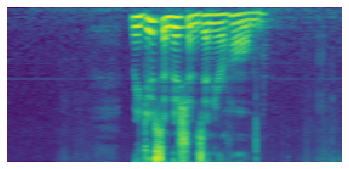

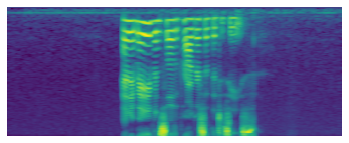

In [ ]:
oa = OpenAudio(files)
item100 = oa.encodes(100)
item100.show()
a2s = AudioToSpec(cfg)
a2s(item100).show()
db_mel_pipe = Pipeline([oa, AudioToSpec(cfg), MelScale(), AmplitudeToDB(),torch.detach], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00340.wav


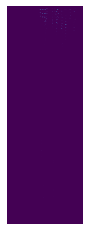

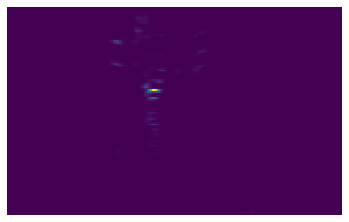

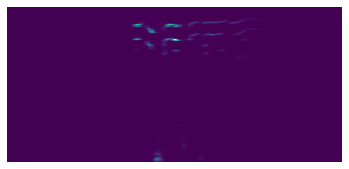

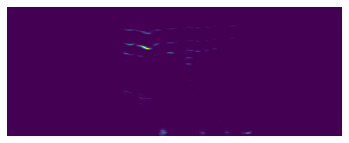

In [ ]:
mel_cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
oa = OpenAudio(files)
item100 = oa.encodes(100)
item100.show()
a2s = AudioToSpec(cfg)
a2s(item100).show()
db_mel_pipe = Pipeline([oa, AudioToMelSpec(mel_cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### MFCC Pipe

In [ ]:
mfcc_cfg = {"n_mfcc" : 20}
db_mel_pipe = Pipeline([oa, AudioToMFCC(mfcc_cfg), ], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

In [ ]:
#export
# def AudioToMelSpec(settings, mfcc=False, to_db_scale=True, delta=False, **kwargs):
#     def _inner(ai:AudioItem)->AudioSpectrogram:
#         mel = MelSpectrogram(**(settings.mel_args()))(ai.sig)
#         if to_db_scale and not mfcc: mel = AmplitudeToDB(top_db=settings.top_db)(mel)
#         return AudioSpectrogram.create(mel.detach(), settings=settings)
#     return _inner

In [ ]:
# #export
# class AudioToSpec(Transform):
#     def __init__(self, sg_cfg): 
#         self.config = sg_cfg
        
#     def encodes(self, item:AudioItem):
#         if self.config.mfcc: 
#             mel = MFCC(sr=item.sr, n_mfcc=self.config.sg_cfg.n_mfcc, melkwargs=self.config.sg_cfg.mel_args())(item.sig)
#         else:
#             mel = MelSpectrogram(**(self.config.mel_args()))(item.sig)
#             if self.config.sg_cfg.to_db_scale: 
#                 mel = AmplitudeToDB(top_db=self.config.sg_cfg.top_db)(mel)
#         if self.config.standardize: mel = standardize(mel)
#         return AudioSpectrogram(mel.detach())
    
#     #Spectrograms can't be decoded so we just return the object
#     def decodes(self, o)->AudioSpectrogram:
#         return o

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Update SpectrogramConfig to give users option to change all the stuff MelSpectrogram accepts, like window_fn, win_length..etc</div>

- sample_rate (int) – Sample rate of audio signal. (Default: 16000)
- win_length (int) – Window size. (Default: n_fft)
- hop_length (int, optional) – Length of hop between STFT windows. ( Default: win_length // 2)
- n_fft (int, optional) – Size of FFT, creates n_fft // 2 + 1 bins
- f_min (float) – Minimum frequency. (Default: 0.)
- f_max (float, optional) – Maximum frequency. (Default: None)
- pad (int) – Two sided padding of signal. (Default: 0)
- n_mels (int) – Number of mel filterbanks. (Default: 128)
- window_fn (Callable[[..], torch.Tensor]) – A function to create a window tensor that is applied/multiplied to each frame/window. (Default: torch.hann_window)
- wkwargs (Dict[.., ..]) – Arguments for window function. (Default: None)

In [ ]:
#export
@dataclass
class SpectrogramConfig:
    '''Configuration for how Spectrograms are generated'''
    f_min: float = 0.
    f_max: float = 22050.
    hop: int = 256
    n_fft: int = 2560
    n_mels: int = 128
    pad: int = 0
    to_db_scale: bool = True
    top_db: int = 100
    ws: int = None
    n_mfcc: int = 20
    def mel_args(self):
        mel_dict = {k:v for k, v in asdict(self).items() if k in ["f_min", "f_max", "n_fft", 
                                                      "n_mels", "pad"]}
        mel_dict['hop_length'] = self.hop
        return mel_dict
    
    def mfcc_args(self):
        return {'melkwargs':self.mel_args(), 'n_mfcc':self.n_mfcc}


In [ ]:
items = get_audio_files(p); items

In [ ]:
oa = OpenAudio(items)
item100 = oa.encodes(100)
item100.show()

## Export

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)